In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Get EfficientNet-PyTorch
!pip install efficientnet_pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os
from PIL import Image
import datetime 
from efficientnet_pytorch import EfficientNet 

import time
import warnings
import seaborn as sn 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
warnings.filterwarnings("ignore")



  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=85b1f38b18d7e76c7a1162646b3e9a1d23db379d980c3d3015f83e90484c5e83
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
!pip install vit-pytorch

## Use GPU

In [ ]:
# Use GPU 
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


## Data Exploration

images: 780


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


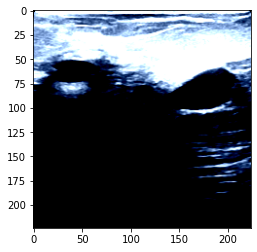

In [ ]:
### Apply Data Augmentation method 

"""
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.RandomHorizontalFlip(p=0.3),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485,0.456, 0.406],[0.229,0.224, 0.225])
                                    ])
                            
test_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485,0.456, 0.406],[0.229,0.224, 0.225])
                                    ])
"""
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485,0.456, 0.406],[0.229,0.224, 0.225])
                                    ])
                            
test_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485,0.456, 0.406],[0.229,0.224, 0.225])
                                    ])

#data_path = '/content/drive/MyDrive/Dataset_BUSI'
data_path1 = '/content/drive/MyDrive/Dataset_BUSI_5_fold/kfold5'
img_names = []

for folder, subfolder, filenames in os.walk(data_path1):
    for img in filenames:
        img_names.append(folder+ '\\' + img)
print('images:', len(img_names))
    
# For preprocess in this dataset     
im = Image.open('/content/drive/MyDrive/Dataset_BUSI_5_fold/kfold5/train5/benign/benign (100).png')
#/content/drive/MyDrive/Dataset_BUSI_5_fold/kfold3/test3/benign3
im = train_transform(im)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))
plt.show()


## Google Drive data path 

In [ ]:

root = '/content/drive/MyDrive/Dataset_BUSI_5_fold/kfold5'


train_data = datasets.ImageFolder(os.path.join(root,'train5'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'test5'), transform = test_transform)

print("train data::::::", len(train_data))

train_loader = DataLoader(train_data, batch_size = 24, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 24, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available: {len(test_data)}')

print(f'Training loader: {len(train_loader)}')
print(f'Testing loader: {len(test_loader)}')


train data:::::: 624
['benign', 'malignant', 'normal']
Training images available: 624
Testing images available: 156
Training loader: 26
Testing loader: 7


## Count Number of Parameters

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters()]
    print(f'_________\n {sum(params)}')
    print("Number of parameters:")

## Validate Model

In [ ]:
def validate(model,train_loader, val_loader):
    train_correct = []
    for name, loader in [('train',train_loader),('val', val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _,predicted = torch.max(outputs,dim = 1)
                correct += int((predicted==labels).sum())
                total += labels.shape[0]
            train_correct.append(correct)
        
        print('Acccuracy {} : {:2f} '. format(name,correct/total))


## Display Confusion Matrix

In [ ]:
def display_confusion_matrix(test_data, model, class_names):
    nb_classes=3
    batch_size =156
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    test_load_all = DataLoader(test_data, batch_size = batch_size, shuffle = False)

    with torch.no_grad():
        correct = 0
        for x_test, y_test in test_load_all:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            y_predicted = model(x_test)
            _,predicted = torch.max(y_predicted, dim = 1)
            correct += int((predicted ==y_test).sum())
            for t, p in zip(y_test.view(-1), predicted.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(torch.sum(confusion_matrix.diag())/batch_size)
   
  
    

    

## Training Loop with Evaluation

In [ ]:
train_losses =  []
test_losses = []
train_correct = []
test_correct = []
def pretrained_model(model, test_loader, train_loader):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    epochs = 60
    max_trn_batch = 800
    max_tst_batch = 300


    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0

        for b, (X_train,y_train) in enumerate(train_loader):
            if b ==max_trn_batch:
                break
            b +=1
            # Load the model to GPU
            X_train = X_train.to(device)
            y_train = y_train.to(device)

            #Apply the model
            y_pred = model(X_train)
            loss = criterion(y_pred,y_train)

            #Tally the number of correct parameters
            _,predicted = torch.max(y_pred,dim= 1)
            trn_corr += int((predicted == y_train).sum())

            # Update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if b%10== 0:
                print(f'epoch: {i:2} batch: {b:4} [{31*b:6}/620] loss:{loss.item():10.8f} accuracy:{trn_corr*100/(31*b) : 7.3f}%')

            train_losses.append(loss)
            train_correct.append(trn_corr)
            """
            with torch.no_grad():
                for b, (X_test, y_test) in enumerate(test_loader):
                    if b == max_tst_batch:
                        break
                    X_test = X_test.to(device)
                    y_test = y_test.to(device)
                    
                    y_val = model(X_test)
                    _,predicted = torch.max(y_val, 1)
                    tst_corr += int((predicted == y_test).sum())
            
            loss = criterion(y_val, y_test)
            test_losses.append(loss)
            test_correct.append(tst_corr)
            """

## Training Loop

In [ ]:
# Train the model

def train_model(num_epochs,optimizer, model,criterion,train_loader):
  loss_list = []
  acc_list = []
  total_step = len(train_loader)

  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          # Run the forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss_list.append(loss.item())

          # Backprop and perform Adam optimisation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Track the accuracy
          total = labels.size(0)
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()
          acc_list.append(correct / total)

          if (i + 1) % 12 == 0:
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                            (correct / total) * 100))
              
  print("Mean Accuracy:{}".format(np.mean(acc_list)))
  #return acc_list,loss_list


## Training Loop with L2_Regularization

In [ ]:
# Train the model

def train_model_l2(num_epochs,optimizer, model,criterion,train_loader,l2_lambda=0.0001):
  loss_list = []
  acc_list = []
  total_step = len(train_loader)

  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          # Run the forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss_list.append(loss.item())

          # L2 Regularization
      
          l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
          loss = loss + l2_lambda * l2_norm
        
          # Backprop and perform Adam optimisation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          

          # Track the accuracy
          total = labels.size(0)
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()
          acc_list.append(correct / total)

          if (i + 1) % 26 == 0:
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                            (correct / total) * 100))
              
  print("Mean Accuracy:{}".format(np.mean(acc_list)))
  #return acc_list,loss_list

## Weight Normalization

In [ ]:
nSamples = [350,168,106]
normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
normedWeights = torch.FloatTensor(normedWeights).to(device)
print(normedWeights)

tensor([0.4391, 0.7308, 0.8301], device='cuda:0')


## Vision Transformer (ViT)

In [ ]:
!pip install timm
import timm
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

In [ ]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)


## Distilled Vision Transformers

In [ ]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model

In [ ]:
from timm.models import create_model
model_name = "deit_base_patch16_224"
nb_classes = 3
drop_rate = 0.0
drop_path_rate = 0.1
drop_block = None

model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

i = 0
for child in model.blocks.children():
    if i < 9:
        for param in child.parameters():
            param.requires_grad = False
    else:
        for param in child.parameters():
            param.requires_grad = True
    i +=1

model.head  =  nn.Sequential(nn.Linear(768, 1024),
                     nn.Dropout(0.2),
                      nn.ReLU(),
nn.Linear(1024, 512),
                     nn.Dropout(0.2),
                      nn.ReLU(),
 nn.Linear(512, 3)

        )
loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

train_model_l2(num_epochs=10,optimizer=optimizer, model= model.to(device),criterion=loss_fn,train_loader=train_loader)
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model = model.to(device),class_names=class_names)

Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth



Epoch [1/10], Step [26/26], Loss: 34.3136, Accuracy: 58.33%
Epoch [2/10], Step [26/26], Loss: 33.6212, Accuracy: 79.17%
Epoch [3/10], Step [26/26], Loss: 33.1941, Accuracy: 100.00%
Epoch [4/10], Step [26/26], Loss: 32.9998, Accuracy: 100.00%
Epoch [5/10], Step [26/26], Loss: 32.8365, Accuracy: 100.00%
Epoch [6/10], Step [26/26], Loss: 32.6760, Accuracy: 100.00%
Epoch [7/10], Step [26/26], Loss: 32.5226, Accuracy: 100.00%
Epoch [8/10], Step [26/26], Loss: 32.3611, Accuracy: 100.00%
Epoch [9/10], Step [26/26], Loss: 32.2061, Accuracy: 100.00%
Epoch [10/10], Step [26/26], Loss: 32.0530, Accuracy: 100.00%
Mean Accuracy:0.9416666666666668
tensor([[74., 11.,  2.],
        [ 3., 37.,  2.],
        [ 4.,  0., 23.]])
tensor(0.8590)


In [ ]:
model = create_model(
        model_name,
        pretrained=True,
        #num_classes=nb_classes,
        drop_rate=drop_rate,
        drop_path_rate=drop_path_rate,
        drop_block_rate=drop_block,
        #in_chans=1
    )

model.head = nn.Linear(768, 3)
loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

train_model_l2(num_epochs=10,optimizer=optimizer, model= model.to(device),criterion=loss_fn,train_loader=train_loader)
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model = model.to(device),class_names=class_names)

Epoch [1/10], Step [26/26], Loss: 33.7986, Accuracy: 87.50%
Epoch [2/10], Step [26/26], Loss: 33.3356, Accuracy: 87.50%
Epoch [3/10], Step [26/26], Loss: 32.8778, Accuracy: 95.83%
Epoch [4/10], Step [26/26], Loss: 32.5486, Accuracy: 100.00%
Epoch [5/10], Step [26/26], Loss: 32.3319, Accuracy: 95.83%
Epoch [6/10], Step [26/26], Loss: 32.0703, Accuracy: 95.83%
Epoch [7/10], Step [26/26], Loss: 31.7858, Accuracy: 95.83%
Epoch [8/10], Step [26/26], Loss: 31.4436, Accuracy: 100.00%
Epoch [9/10], Step [26/26], Loss: 31.1527, Accuracy: 100.00%
Epoch [10/10], Step [26/26], Loss: 30.8962, Accuracy: 100.00%
Mean Accuracy:0.9320512820512821
tensor([[74., 13.,  0.],
        [ 2., 39.,  1.],
        [14.,  1., 12.]])
tensor(0.8013)


### Model 1) vit_small_resnet26d_224

In [ ]:
i = 0
for child in model.blocks.children():
    if i < 9:
        for param in child.parameters():
            param.requires_grad = False
    else:
        for param in child.parameters():
            param.requires_grad = True
    i +=1

In [ ]:
model = timm.create_model("vit_small_resnet26d_224", pretrained=True)
model

In [ ]:

model = timm.create_model("vit_small_resnet26d_224", pretrained=True)
i=0
for child in model.children():
    if i<4:
      child.requires_grad = False
    else:
      child.requires_grad = True
    i+=1
"""

for child in model.head.children():
        for param in child.parameters():
            param.requires_grad = True
 
"""
model.head = nn.Linear(model.head.in_features, 3)

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

train_model_l2(num_epochs=10,optimizer=optimizer, model= model.to(device),criterion=loss_fn,train_loader=train_loader)

# Display confusion matrix
display_confusion_matrix(test_data=test_data, model = model.to(device),class_names=class_names)


Epoch [1/10], Step [26/26], Loss: 20.0155, Accuracy: 79.17%
Epoch [2/10], Step [26/26], Loss: 19.6037, Accuracy: 87.50%
Epoch [3/10], Step [26/26], Loss: 19.3608, Accuracy: 100.00%
Epoch [4/10], Step [26/26], Loss: 19.3307, Accuracy: 100.00%
Epoch [5/10], Step [26/26], Loss: 19.2861, Accuracy: 100.00%
Epoch [6/10], Step [26/26], Loss: 19.8615, Accuracy: 87.50%
Epoch [7/10], Step [26/26], Loss: 19.2148, Accuracy: 100.00%
Epoch [8/10], Step [26/26], Loss: 19.1939, Accuracy: 100.00%
Epoch [9/10], Step [26/26], Loss: 19.2063, Accuracy: 95.83%
Epoch [10/10], Step [26/26], Loss: 19.1036, Accuracy: 100.00%
Mean Accuracy:0.9323717948717949
tensor([[69., 14.,  4.],
        [ 5., 35.,  2.],
        [ 4.,  2., 21.]])
tensor(0.8013)


### Model 2) vit_base_resnet50d_224

In [ ]:
model = timm.create_model("vit_base_resnet50d_224", pretrained=True)
i=0
for child in model.children():
    if i<4:
      child.requires_grad = False
    else:
      child.requires_grad = True
    i+=1

model.head = nn.Linear(model.head.in_features, 3)

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

train_model_l2(num_epochs=10,optimizer=optimizer, model= model.to(device),criterion=loss_fn,train_loader=train_loader)
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model = model.to(device),class_names=class_names)


Epoch [1/10], Step [26/26], Loss: 46.4341, Accuracy: 50.00%
Epoch [2/10], Step [26/26], Loss: 46.0134, Accuracy: 50.00%
Epoch [3/10], Step [26/26], Loss: 45.8512, Accuracy: 45.83%
Epoch [4/10], Step [26/26], Loss: 45.6752, Accuracy: 70.83%
Epoch [5/10], Step [26/26], Loss: 45.1329, Accuracy: 87.50%
Epoch [6/10], Step [26/26], Loss: 44.7393, Accuracy: 95.83%
Epoch [7/10], Step [26/26], Loss: 44.5226, Accuracy: 95.83%
Epoch [8/10], Step [26/26], Loss: 44.3856, Accuracy: 100.00%
Epoch [9/10], Step [26/26], Loss: 44.3605, Accuracy: 95.83%
Epoch [10/10], Step [26/26], Loss: 44.2257, Accuracy: 100.00%
Mean Accuracy:0.7846153846153846
tensor([[71., 14.,  2.],
        [ 8., 33.,  1.],
        [ 7.,  0., 20.]])
tensor(0.7949)


### Model 3) vit_base_patch16_224

In [ ]:

model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.head = nn.Linear(model.head.in_features, 3)

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

#train_model(num_epochs=10,optimizer=optimizer, model= model.to(device),criterion=loss_fn,train_loader=train_loader)
train_model_l2(num_epochs=10,optimizer=optimizer, model= model.to(device),criterion=loss_fn,train_loader=train_loader)
# Display confusion matrix

display_confusion_matrix(test_data=test_data, model = model.to(device),class_names=class_names)


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


Epoch [1/10], Step [26/26], Loss: 59.1012, Accuracy: 83.33%
Epoch [2/10], Step [26/26], Loss: 58.2774, Accuracy: 87.50%
Epoch [3/10], Step [26/26], Loss: 57.4300, Accuracy: 91.67%
Epoch [4/10], Step [26/26], Loss: 56.5614, Accuracy: 100.00%
Epoch [5/10], Step [26/26], Loss: 55.8236, Accuracy: 100.00%
Epoch [6/10], Step [26/26], Loss: 55.0910, Accuracy: 100.00%
Epoch [7/10], Step [26/26], Loss: 54.3392, Accuracy: 100.00%
Epoch [8/10], Step [26/26], Loss: 53.7260, Accuracy: 95.83%
Epoch [9/10], Step [26/26], Loss: 52.9477, Accuracy: 100.00%
Epoch [10/10], Step [26/26], Loss: 52.2828, Accuracy: 100.00%
Mean Accuracy:0.9302884615384616
tensor([[66., 17.,  4.],
        [ 2., 40.,  0.],
        [ 2.,  0., 25.]])
tensor(0.8397)


### Model 4) vit_small_patch16_224

In [ ]:

vit_sp224 = timm.create_model("vit_small_patch16_224", pretrained=True)
"""
for param in vit_sp224.parameters():
    param.requires_grad = False
"""
vit_sp224.head = nn.Linear(vit_sp224.head.in_features, 3)

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.Adam(vit_sp224.parameters(), lr = 0.0001)

train_model_l2(num_epochs=10,optimizer=optimizer, model= vit_sp224.to(device),criterion=loss_fn,train_loader=train_loader)

# Display confusion matrix

display_confusion_matrix(test_data=test_data, model = vit_sp224.to(device),class_names=class_names)

Epoch [1/10], Step [26/26], Loss: 14.3248, Accuracy: 83.33%
Epoch [2/10], Step [26/26], Loss: 14.0703, Accuracy: 91.67%
Epoch [3/10], Step [26/26], Loss: 13.7856, Accuracy: 100.00%
Epoch [4/10], Step [26/26], Loss: 13.6870, Accuracy: 100.00%
Epoch [5/10], Step [26/26], Loss: 13.5638, Accuracy: 100.00%
Epoch [6/10], Step [26/26], Loss: 13.4826, Accuracy: 100.00%
Epoch [7/10], Step [26/26], Loss: 13.4485, Accuracy: 95.83%
Epoch [8/10], Step [26/26], Loss: 13.2885, Accuracy: 100.00%
Epoch [9/10], Step [26/26], Loss: 13.1794, Accuracy: 100.00%
Epoch [10/10], Step [26/26], Loss: 13.6179, Accuracy: 87.50%
Mean Accuracy:0.9511217948717949
tensor([[36., 17., 34.],
        [ 3., 30.,  9.],
        [ 1.,  0., 26.]])
tensor(0.5897)


# Training the model with ImageNet pretrained weights ##########

### Model 5) Training with VGG16

In [ ]:
vgg16 = models.vgg16(pretrained=True)
"""
i = 0
for child in model.blocks.children():
    if i < 9:
        for param in child.parameters():
            param.requires_grad = False
    else:
        for param in child.parameters():
            param.requires_grad = True
    i +=1
for param in vgg16.parameters():
    param.requires_grad = False
"""
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
#loss_fn = nn.NLLLoss(weight=normedWeights)
optimizer = torch.optim.Adam(vgg16.parameters(), lr = 0.0001)

train_model_l2(num_epochs=10,optimizer=optimizer, model= vgg16.to(device),criterion=loss_fn,train_loader=train_loader)
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model = vgg16.to(device),class_names=class_names)

Epoch [1/10], Step [26/26], Loss: 1.6692, Accuracy: 75.00%
Epoch [2/10], Step [26/26], Loss: 1.4961, Accuracy: 70.83%
Epoch [3/10], Step [26/26], Loss: 1.1565, Accuracy: 79.17%
Epoch [4/10], Step [26/26], Loss: 1.9086, Accuracy: 87.50%
Epoch [5/10], Step [26/26], Loss: 0.9887, Accuracy: 91.67%
Epoch [6/10], Step [26/26], Loss: 1.2452, Accuracy: 79.17%
Epoch [7/10], Step [26/26], Loss: 0.9696, Accuracy: 91.67%
Epoch [8/10], Step [26/26], Loss: 0.8042, Accuracy: 95.83%
Epoch [9/10], Step [26/26], Loss: 0.9067, Accuracy: 91.67%
Epoch [10/10], Step [26/26], Loss: 0.8221, Accuracy: 95.83%
Mean Accuracy:0.8661858974358975
tensor([[52., 22., 13.],
        [ 4., 38.,  0.],
        [ 4.,  1., 22.]])
tensor(0.7179)


### Model 6) Training with wide_resnet50_2 


In [ ]:
wide_resnet50 = models.wide_resnet50_2(pretrained=True)
"""
for param in wide_resnet50.parameters():
    param.requires_grad = False
"""

wide_resnet50.fc = nn.Linear(in_features=2048,out_features = 3)
loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.Adam(wide_resnet50.parameters(), lr = 0.0001)

train_model_l2(num_epochs=10,optimizer=optimizer, model= wide_resnet50.to(device),criterion=loss_fn,train_loader=train_loader)

# Display confusion matrix
display_confusion_matrix(test_data=test_data, model = wide_resnet50.to(device),class_names=class_names)


Epoch [1/10], Step [26/26], Loss: 1.5946, Accuracy: 75.00%
Epoch [2/10], Step [26/26], Loss: 1.0172, Accuracy: 100.00%
Epoch [3/10], Step [26/26], Loss: 1.0344, Accuracy: 100.00%
Epoch [4/10], Step [26/26], Loss: 1.0537, Accuracy: 95.83%
Epoch [5/10], Step [26/26], Loss: 1.0070, Accuracy: 100.00%
Epoch [6/10], Step [26/26], Loss: 1.0034, Accuracy: 100.00%
Epoch [7/10], Step [26/26], Loss: 1.0379, Accuracy: 100.00%
Epoch [8/10], Step [26/26], Loss: 0.9924, Accuracy: 100.00%
Epoch [9/10], Step [26/26], Loss: 1.0149, Accuracy: 100.00%


## Training with Timmm Models

In [ ]:
!pip install resnest --pre

In [ ]:
nasnetalarge = timm.create_model("nasnetalarge", pretrained=True)
print(nasnetlarge)
nasnetalarge.fc = nn.Linear(in_features=2048, out_features=3, bias=True)

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.SGD(nasnetalarge.parameters(), lr = 0.001)

train_model_l2(num_epochs=10,optimizer=optimizer, model= nasnetalarge.to(device),criterion=loss_fn,train_loader=train_loader)



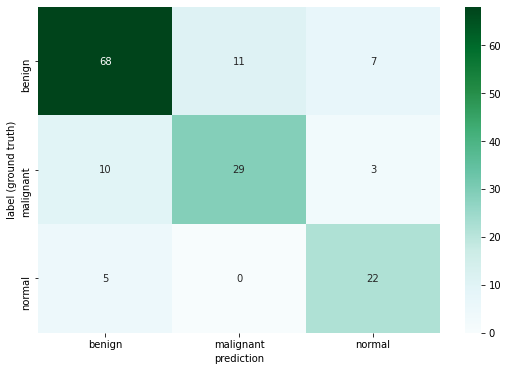

In [ ]:
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model = model_resnest.to('cpu'),class_names=class_names)

## Training with Densenet121

In [ ]:
densenet121 = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
"""
for param in densenet121.parameters():
    param.requires_grad = False
"""

densenet121.classifier = nn.Linear(in_features=1024, out_features=3, bias=True)

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.SGD(densenet121.parameters(), lr = 0.001)

acc_list,loss_list = train_model_l2(num_epochs=10,optimizer=optimizer, model= densenet121.to(device),criterion=loss_fn,train_loader=train_loader)


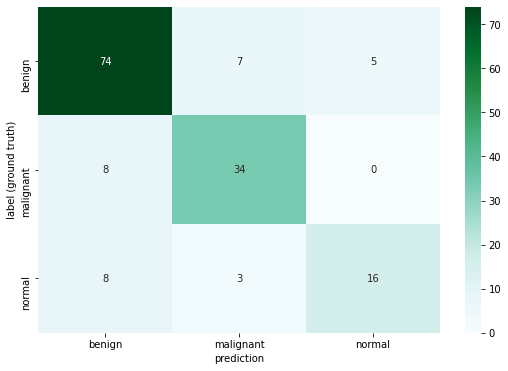

In [ ]:
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model = densenet121.to('cpu'),class_names=class_names)

## Training with GoogleNet


In [ ]:
googlenet = models.googlenet(pretrained=True)
"""
for param in googlenet.parameters():
    param.requires_grad = False
"""
googlenet.fc= nn.Linear(in_features=1024, out_features=3, bias=True)

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.SGD(googlenet.parameters(), lr = 0.001)

train_model_l2(num_epochs=10,optimizer=optimizer, model= googlenet.to(device),criterion=loss_fn,train_loader=train_loader)


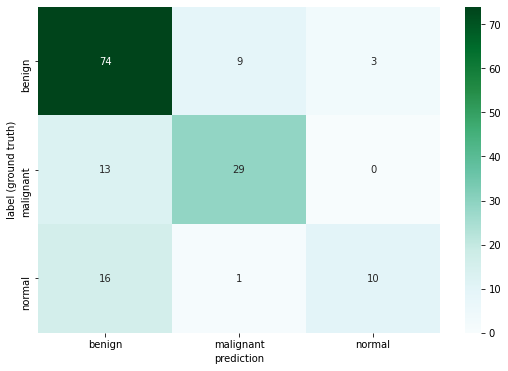

In [ ]:
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model = googlenet.to('cpu'),class_names=class_names)

## Training with Densenet161

In [ ]:
densenet161 = models.densenet161(pretrained=True)
"""
for param in densenet161.parameters(): #Freeze weights
    param.requires_grad = False
"""
densenet161.classifier = nn.Linear(in_features=2208, out_features=3, bias=True)

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.SGD(densenet161.parameters(), lr = 0.001)

acc_list,loss_list= train_model_l2(num_epochs=30,optimizer=optimizer, model= densenet161.to(device),criterion=loss_fn,train_loader=train_loader)


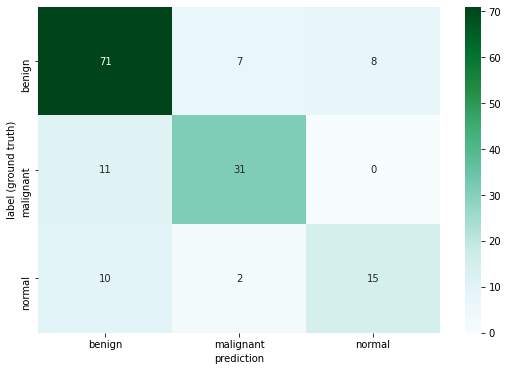

In [ ]:
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model = densenet161.to('cpu'),class_names=class_names)

##  Training with Inceptionv3

In [ ]:

InceptionNet_v3 =  models.inception_v3(pretrained=True)
InceptionNet_v3.aux_logits = False
"""
# we want to frezee the pre-trained weights and biases 
for param in InceptionNet_v3.parameters():
    param.requires_grad = False
"""

InceptionNet_v3.fc = nn.Linear(in_features=2048, out_features=3, bias=True)

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.SGD(InceptionNet_v3.parameters(), lr = 0.001)

acc_list,loss_list= train_model_l2(num_epochs=30,optimizer=optimizer, model= InceptionNet_v3.to(device),criterion=loss_fn,train_loader=train_loader)


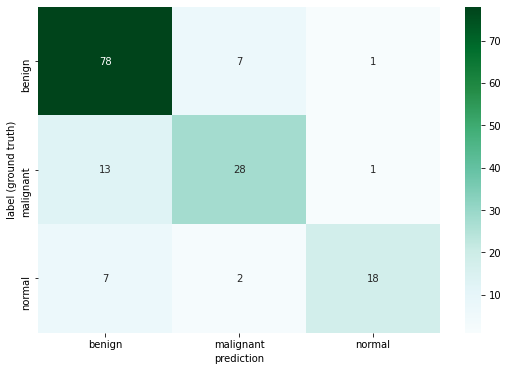

In [ ]:
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model =InceptionNet_v3.to('cpu'),class_names=class_names)

## Training with resnext50_32x4d 

In [ ]:
resnext50 = models.resnext50_32x4d(pretrained=True)
"""
for param in resnext50.parameters():
    param.requires_grad = False
"""
resnext50.fc = nn.Linear(in_features=2048,out_features=3)


loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.SGD(resnext50.parameters(), lr = 0.001)

acc_list,loss_list= train_model_l2(num_epochs=30,optimizer=optimizer, model= resnext50.to(device),criterion=loss_fn,train_loader=train_loader)


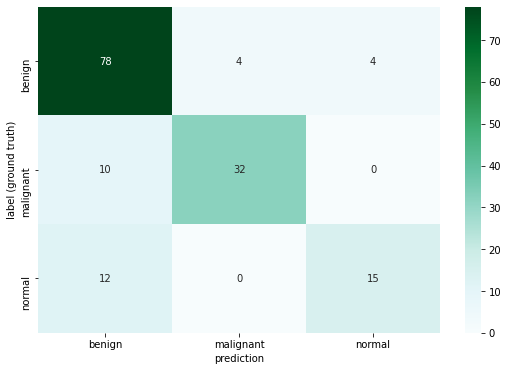

In [ ]:
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model =resnext50.to('cpu'),class_names=class_names)

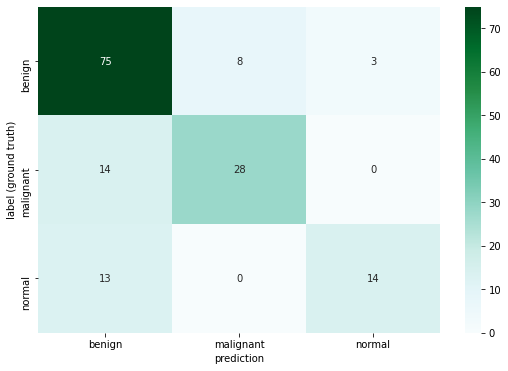

In [ ]:
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model =wide_resnet50.to('cpu'),class_names=class_names)

## Training with EfficientNetb0

In [ ]:
efficientnet= EfficientNet.from_pretrained('efficientnet-b0')
"""
for param in efficientnet.parameters():
    param.requires_grad = False
"""
efficientnet._fc = nn.Linear(in_features=1280,out_features = 3)


loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.SGD(efficientnet.parameters(), lr = 0.001)

acc_list,loss_list = train_model_l2(num_epochs=30,optimizer=optimizer, model= efficientnet.to(device),criterion=loss_fn,train_loader=train_loader)



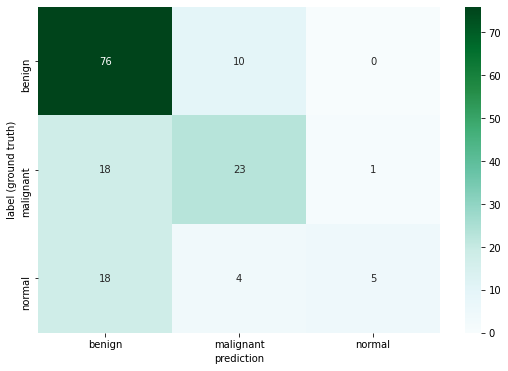

In [ ]:
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model =efficientnet.to('cpu'),class_names=class_names)

## Training with Nasnet Large

In [ ]:
!pip install pretrainedmodels
import pretrainedmodels

print(pretrainedmodels.model_names)

In [ ]:

model_name = 'nasnetalarge' # could be fbresnet152 or inceptionresnetv2

nasnet_large = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/nasnetalarge-a1897284.pth" to /root/.cache/torch/hub/checkpoints/nasnetalarge-a1897284.pth


In [ ]:

nasnet_large.last_linear = nn.Linear(in_features=4032, out_features=3) 


loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.SGD(nasnet_large.parameters(), lr = 0.001)

train_model_l2(num_epochs=30,optimizer=optimizer, model= nasnet_large.to(device),criterion=loss_fn,train_loader=train_loader)


## Training with Nasnet Mobile

In [ ]:
model_name = 'nasnetamobile' # could be fbresnet152 or inceptionresnetv2
nasnet_mobile = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/nasnetamobile-7e03cead.pth" to /root/.cache/torch/hub/checkpoints/nasnetamobile-7e03cead.pth


In [ ]:
"""
for param in nasnet_mobile .parameters():
    param.requires_grad = False
"""

nasnet_mobile.last_linear = nn.Linear(in_features=1056, out_features=3) 

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.SGD(nasnet_mobile.parameters(), lr = 0.001)

train_model_l2(num_epochs=30,optimizer=optimizer, model= nasnet_mobile.to(device),criterion=loss_fn,train_loader=train_loader)


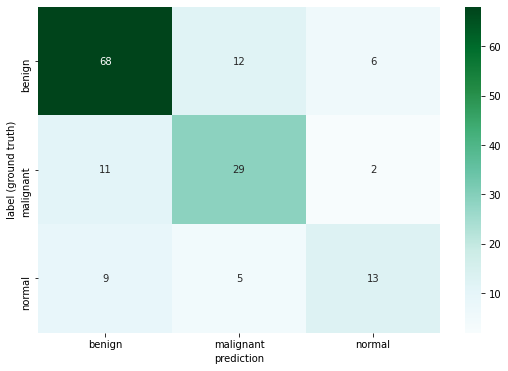

In [ ]:
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model =nasnet_mobile.to('cpu'),class_names=class_names)

## Training with Shufflenet

In [ ]:
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
"""
for param in shufflenet.parameters():
    param.requires_grad = False
"""
shufflenet.fc = nn.Linear(in_features=1024,out_features = 3)

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.SGD(shufflenet.parameters(), lr = 0.001)
acc_list,loss_list = train_model_l2(num_epochs=30,optimizer=optimizer, model= shufflenet.to(device),criterion=loss_fn,train_loader=train_loader)


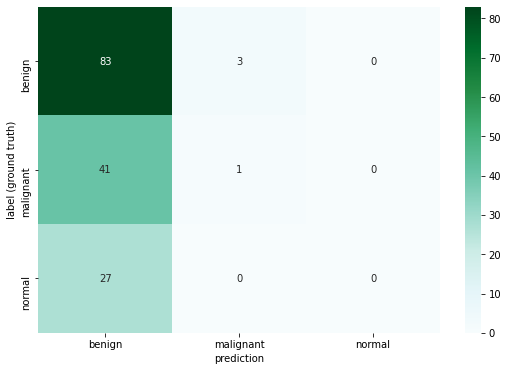

In [ ]:
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model =shufflenet.to('cpu'),class_names=class_names)


## Training with Squeezenet

In [ ]:
squeezenet = models.squeezenet1_0(pretrained=True)
"""
for param in squeezenet.parameters():
    param.requires_grad = False
"""
squeezenet.classifier[1] = nn.Conv2d(512, 3, kernel_size=(1, 1), stride=(1, 1))

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.SGD(squeezenet.parameters(), lr = 0.001)
acc_list,loss_list = train_model_l2(num_epochs=30,optimizer=optimizer, model= squeezenet.to(device),criterion=loss_fn,train_loader=train_loader)


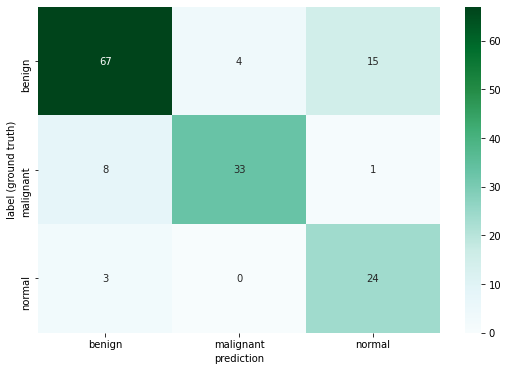

In [ ]:
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model = squeezenet.to('cpu'),class_names=class_names)


## Training with Ensemble (Resnet18+Densenet121+Efficientnetb0)

In [ ]:
class Transition(nn.Module):
  def __init__(self,in_features):
    super(Transition,self).__init__()
    self.bn1 = nn.BatchNorm2d(in_features)
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(in_features,in_features//2, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(in_features//2)
    
  def forward(self,x):
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv1(x)
    x = self.bn2(x)
    x = self.relu(x)
    return x



class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, modelC, nb_classes=3):
        super(MyEnsemble, self).__init__()

        # Remove last linear and avgpool layer
        self.modelA = nn.Sequential(*(list(modelA.children())[:-2])) # resnet50
        self.modelB = nn.Sequential(*(list(modelB.children())[:-1])) # densenet121
        self.modelC = modelC #EfficientNet
        

        
        self.relu = nn.ReLU()
        self.transition = Transition(in_features= 2816)
        self.avgpool = nn.AvgPool2d(7,2)
        # Create new classifier
        self.classifier = nn.Linear(1408, nb_classes)


    def forward(self, x):
        x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
        x2 = self.modelB(x)
        x3 =  self.modelC.extract_features(x)
        
        x = torch.cat((x1, x2, x3), dim=1)
        #print("concatinating:", x.shape)
        x = self.transition(x)
        #print("after transition:", x.shape)
        x = self.avgpool(x)
        
        x = x.view(x.shape[0],-1)
        x = self.classifier(x)
        return x
        
# We use pretrained torchvision models here
modelA = models.resnet18(pretrained=True)
modelB = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
modelC = EfficientNet.from_pretrained('efficientnet-b0')

"""
# Freeze these models
for param in modelA.parameters():
    param.requires_grad_(False)

for param in modelB.parameters():
    param.requires_grad_(False)

for param in modelC.parameters():
    param.requires_grad_(False)
"""
# Create ensemble model
torch.manual_seed(101)

model = MyEnsemble(modelA, modelB, modelC).to(device)

loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
acc_list,loss_list = train_model_l2(num_epochs=30,optimizer=optimizer, model= model,criterion=loss_fn,train_loader=train_loader)

print("Mean accuracy:", np.mean(acc_list))

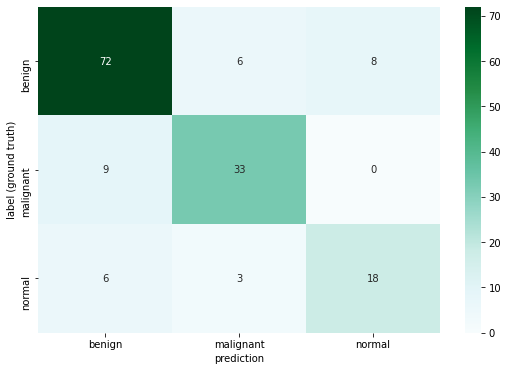

In [ ]:
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model = model.to('cpu'),class_names=class_names)

## Training with Ensemble (VGG16+ResNext+Squeeznet)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
class Transition(nn.Module):
  def __init__(self,in_features):
    super(Transition,self).__init__()
    self.bn1 = nn.BatchNorm2d(in_features)
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(in_features,in_features//2, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(in_features//2)
    
  def forward(self,x):
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv1(x)
    x = self.bn2(x)
    x = self.relu(x)
    return x


class RVSNET(nn.Module):
    def __init__(self, resnext50, vgg16, squeezenet, nb_classes=3):
        super(RVSNET, self).__init__()

        # Remove last linear and avgpool layer
        self.model_res = nn.Sequential(*(list(resnext50.children())[:-2])) # resnext50
        self.model_vgg = nn.Sequential(*list(vgg16.features.children())[:-1]) # vgg16
        self.model_squ = nn.Sequential(*(list(squeezenet.features.children())[:-1])) # squeezenet


        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=2,padding=1)
        self.transition = Transition(in_features= 3072)
        self.avgpool = nn.AvgPool2d(7,2)
        # Create new classifier
        self.classifier = nn.Linear(1536, nb_classes)


    def forward(self, x):
        x1 = self.model_res(x.clone())  # clone to make sure x is not changed by inplace methods
        x2 = self.model_vgg(x)
        x2 = self.conv1(x2)
        x3 = self.model_squ(x)
        x3 = self.conv1(x3)


        x = torch.cat((x1, x2, x3), dim=1)
        #print("concatinating:", x.shape)
        x = self.transition(x)
        #print("after transition:", x.shape)
        x = self.avgpool(x)
        
        x = x.view(x.shape[0],-1)
        x = self.classifier(x)
        return x
    
# We use pretrained torchvision models here
resnext50 = models.resnext50_32x4d(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)

"""
# Freeze these models
for param in modelA.parameters():
    param.requires_grad_(False)

for param in modelB.parameters():
    param.requires_grad_(False)

for param in modelC.parameters():
    param.requires_grad_(False)
"""
# Create ensemble model
torch.manual_seed(101)

model_RVSNET = RVSNET(resnext50, vgg16, squeezenet).to(device)


loss_fn = nn.CrossEntropyLoss(weight=normedWeights)
optimizer = torch.optim.SGD(model_RVSNET.parameters(), lr = 0.001)
train_model_l2(num_epochs=30,optimizer=optimizer, model= model_RVSNET, criterion=loss_fn,train_loader=train_loader,l2_lambda=0.0002)



Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


RuntimeError: ignored

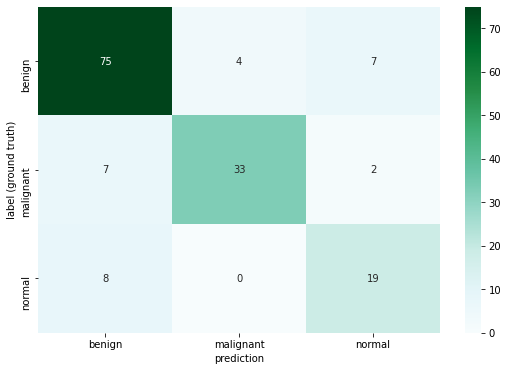

In [ ]:
# Display confusion matrix
display_confusion_matrix(test_data=test_data, model =model_RVSNET.to('cpu'),class_names=class_names)

## Save the Ensemble Model

In [ ]:
save_path = '/content/drive/MyDrive/Pt_ultrason/'
torch.save(model.state_dict(), save_path + 'Ensemble_ultrason.pt')


## Load Ensemble Model

In [ ]:
loaded_model = MyEnsemble(modelA, modelB, modelC).to('cpu')
loaded_model.state_dict(torch.load(save_path + 'Ensemble_ultrason.pt'))

In [ ]:
Load it for evaluation
model = get_model_structure()
state = torch.load(‘path to saved/name.pth’)
model.load_state_dict(state)
model.eval()

In [ ]:
Train it
model = get_model_structure()
learn = Learner(data, model)
learn.fit_one_cycle(64)
learn.save(‘name’, with_opt=False)

In [ ]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
print(torch.nn.functional.softmax(output[0], dim=0))
